In [1]:
%matplotlib inline
import os
import numpy as np
import pandas as pd
import cv2
import sys

sys.path.append("../")
from utils.dataset import OCRDataset
import matplotlib.pyplot as plt

import tensorflow as tf

tf.enable_eager_execution()

# 데이터 셋 
---

ICDAR : [Robust Reading Competition](http://rrc.cvc.uab.es/)

![](http://rrc.cvc.uab.es/files/Challenge4_Overview_v02.png)

In [2]:
# icdar2015년 challenge 4번 데이터셋
dataset = OCRDataset(dataset='icdar2015')

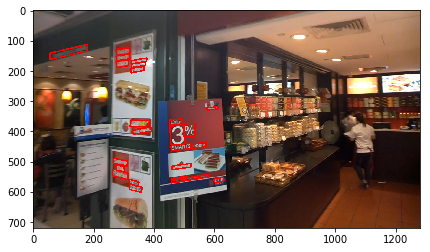

In [3]:
index = 21
plt.figure(figsize=(10,4))
plt.imshow(dataset.show_image(index))
plt.show()

## Data Generator 구성하기
---

![Imgur](https://i.imgur.com/OfnslNB.png)

1) 이미지의 사이즈를 정규화 
----

Model의 Input으로 들어가는 이미지는 $\frac{1}{32}$배로 줄어들게 됩니다.<br>
그렇기 때문에 32로 나뉘어 떨어지지 않으면, <br>
원본 이미지와 Feature Map 사이에서 왜곡이 일어날 수 있습니다.

In [4]:
def normalize_shape(image, polys, scale=32):
    """
    이미지와 좌표들을 배율에 나누어 떨어지도록 정규화
    """
    h, w = image.shape[:2]

    norm_h = np.ceil(h/scale)*scale
    norm_w = np.ceil(w/scale)*scale

    ratio_h = norm_h / h
    ratio_w = norm_w / w
    
    polys = polys.astype(float)
    polys[:,:,0] = polys[:,:,0]*ratio_w # x축에 배율 적용
    polys[:,:,1] = polys[:,:,1]*ratio_h # y축에 배율 적용
    
    image = cv2.resize(image, (int(norm_w),int(norm_h)))
    return image, polys

In [5]:
image, polys = dataset[index]
print("before image shape : {}".format(image.shape))
image, polys = normalize_shape(image, polys)
print("after image shape : {}".format(image.shape))

before image shape : (720, 1280, 3)
after image shape : (736, 1280, 3)


2) Polys들의 방향을 시계방향으로 정렬
----

우리가 이후 작업들어가는 코드들에서는 polys의 각각의 순서가 시계방향임을 가정하고 있습니다.<br>
시계방향을 보장하기 위해서 아래의 코드가 필요합니다.

In [6]:
def reorder_clockwise(polys):
    """
    4개 점들의 순서를 top-left -> top-right -> bottom-right -> bottom-left 즉,
    시계 방향으로 회전하도록 순서를 변경
    """
    if polys.ndim == 2:
        x_sorted = polys[np.argsort(polys[:, 0]), :]

        leftmost = x_sorted[:2, :]
        leftmost = leftmost[np.argsort(leftmost[:, 1]), :]
        (tl, bl) = leftmost

        rightmost = x_sorted[2:, :]
        rightmost = rightmost[np.argsort(rightmost[:, 1]), :]
        (tr, br) = rightmost

        return np.array([tl, tr, br, bl], dtype=np.float32)
    elif polys.ndim == 3:
        return np.stack([reorder_clockwise(poly) for poly in polys])
    else:
        raise ValueError("Wrong Dimension")

In [7]:
# 의도한 대로 작동하는지 검증
ex1 = np.array([
       [[2, 2],
        [4, 2],
        [4, 4],
        [2, 4]],

       [[1, 3],
        [3, 1],
        [5, 3],
        [1, 3]],

       [[2, 1],
        [5, 2],
        [4, 5],
        [1, 4]]])
reorder_clockwise(ex1)

array([[[2., 2.],
        [4., 2.],
        [4., 4.],
        [2., 4.]],

       [[1., 3.],
        [3., 1.],
        [5., 3.],
        [1., 3.]],

       [[2., 1.],
        [5., 2.],
        [4., 5.],
        [1., 4.]]], dtype=float32)

In [8]:
polys = reorder_clockwise(polys)
polys

array([[[499.      , 385.37778 ],
        [536.      , 381.28888 ],
        [536.      , 424.22223 ],
        [499.      , 428.3111  ]],

       [[456.      , 457.95557 ],
        [521.      , 448.75555 ],
        [522.      , 467.15555 ],
        [457.      , 475.33334 ]],

       [[525.      , 451.82224 ],
        [571.      , 445.6889  ],
        [571.      , 461.02222 ],
        [525.      , 466.13333 ]],

       [[452.      , 391.5111  ],
        [499.      , 386.4     ],
        [503.      , 450.8     ],
        [456.      , 455.9111  ]],

       [[328.      , 404.8     ],
        [389.      , 394.5778  ],
        [392.      , 408.8889  ],
        [331.      , 419.1111  ]],

       [[599.      , 569.3778  ],
        [630.      , 564.26666 ],
        [631.      , 577.55554 ],
        [600.      , 582.6667  ]],

       [[267.      , 499.86667 ],
        [312.      , 510.0889  ],
        [311.      , 526.44446 ],
        [265.      , 516.2222  ]],

       [[274.      , 521.3333  ],


3) reference length $r_i$ 구하기
----

$$
r_i = min(D(p_i,p_{(i \% 4) + 1}),D(p_i,P_{((i+2) \% 4) +1}))
$$

$D(p_i,p_j)$는 두 점의 유클리디안 거리입니다.

In [9]:
def get_reference_length(polys):
    """
    polys : (batch size, 4, 2)
    return : 
    rs : (batch size, 4)
    """
    d_1 = np.sqrt(
        np.sum((polys - np.roll(polys,1,axis=1))**2,
               axis=-1))
    d_2 = np.sqrt(
        np.sum((polys - np.roll(polys,-1,axis=1))**2,
               axis=-1))
    rs = np.min([d_1,d_2],axis=0)
    return rs

In [10]:
rs = get_reference_length(polys)
rs

array([[37.22525  , 37.22525  , 37.225246 , 37.225246 ],
       [17.406527 , 18.427149 , 18.427149 , 17.406527 ],
       [14.311096 , 15.333313 , 15.333313 , 14.311096 ],
       [47.277092 , 47.277092 , 47.277092 , 47.277092 ],
       [14.622187 , 14.622157 , 14.622157 , 14.622187 ],
       [13.326451 , 13.326451 , 13.326451 , 13.326451 ],
       [16.47739  , 16.386103 , 16.386103 , 16.47739  ],
       [18.42718  , 17.406496 , 17.406496 , 18.42718  ],
       [22.488892 , 22.488892 , 22.488892 , 22.488892 ],
       [21.466675 , 21.466675 , 21.466675 , 21.466675 ],
       [19.447952 , 20.468885 , 20.468885 , 19.447952 ],
       [16.477373 , 15.624051 , 15.624051 , 16.477373 ],
       [20.542051 , 20.542036 , 20.542036 , 20.542051 ],
       [ 7.155548 ,  8.177765 ,  8.177765 ,  7.155548 ],
       [12.307371 , 11.288825 , 11.288825 , 12.307371 ],
       [ 9.200012 ,  8.177795 ,  8.177795 ,  9.200012 ],
       [ 7.1555786,  7.1555176,  7.1555176,  7.1555786],
       [12.307356 , 12.266663 ,

3) Shrunk quadrangle 구하기
----

아래 그림 (a)에서 초록 색 부분을 채워넣도록 하겠습니다.
![Imgur](https://i.imgur.com/2zsxrB7.png)

In [11]:
def shrink_quandrangle(poly, r, shrink_ratio=0.3):
    dists = np.linalg.norm(poly - np.roll(poly,-1,axis=0),
                           axis=1)

    angle = lambda pt1, pt2 : np.arctan2(pt1[1] - pt2[1],pt1[0]-pt2[0])
    diff = lambda theta : np.array([np.cos(theta), np.sin(theta)])

    if dists[0] + dists[2] > dists[1] + dists[2]:
        theta = angle(poly[1],poly[0])
        poly[0] += shrink_ratio * r[0] * diff(theta)
        poly[1] -= shrink_ratio * r[1] * diff(theta)

        theta = angle(poly[2],poly[3])
        poly[3] += shrink_ratio * r[3] * diff(theta)
        poly[2] -= shrink_ratio * r[2] * diff(theta)

        theta = angle(poly[3],poly[0])
        poly[0] += shrink_ratio * r[0] * diff(theta)
        poly[3] -= shrink_ratio * r[3] * diff(theta)

        theta = angle(poly[2],poly[1])
        poly[1] += shrink_ratio * r[1] * diff(theta)
        poly[2] -= shrink_ratio * r[2] * diff(theta)
    else:
        theta = angle(poly[3],poly[0])
        poly[0] += shrink_ratio * r[0] * diff(theta)
        poly[3] -= shrink_ratio * r[3] * diff(theta)

        theta = angle(poly[2],poly[1])
        poly[1] += shrink_ratio * r[1] * diff(theta)
        poly[2] -= shrink_ratio * r[2] * diff(theta)

        theta = angle(poly[1],poly[0])
        poly[0] += shrink_ratio * r[0] * diff(theta)
        poly[1] -= shrink_ratio * r[1] * diff(theta)

        theta = angle(poly[2],poly[3])
        poly[3] += shrink_ratio * r[3] * diff(theta)
        poly[2] -= shrink_ratio * r[2] * diff(theta)
        
    return poly

In [12]:
origin_polys = polys.copy()
new_polys=[]
for poly, r in zip(polys,rs):
    new_polys.append(shrink_quandrangle(poly.copy(),r.copy(),0.3))
new_polys = np.stack(new_polys)

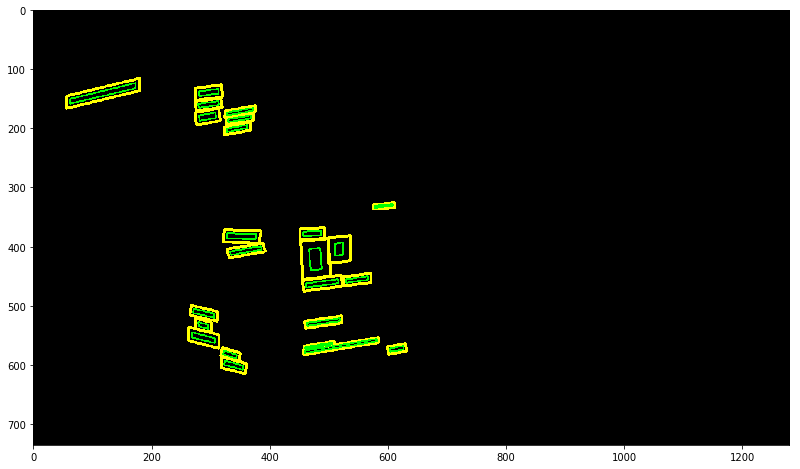

In [13]:
blank = np.zeros_like(image)
cv2.polylines(blank,
              origin_polys.astype(np.int32),
              True,(255,255,0),
              3)
cv2.polylines(blank,
              new_polys.astype(np.int32),
              True,(0,255,0),
              2)
plt.figure(figsize=(15,8))
plt.imshow(blank)
plt.show()

4) Fitted Rectangle 구하기
----

![Imgur](https://i.imgur.com/VYYp4R5.png)

논문과는 약간 다른 방식으로 구현하였습니다.<br>
아래 붉은색 박스가 현재 구현된 방식입니다.

![Imgur](https://i.imgur.com/mRjHYRP.png)

In [14]:
def calculate_point_line_distance(pt1, pt2, pt0):
    """
    한 점과 2 점을 잇는 직선 간의 거리를 계산

    :param pt1, pt2: 직선을 구성하는 2개의 점
    :param pt0: (x0, y0) 목표 점
    :return:
        직선과 두 점의 수직 거리를 계산
    """
    x1, y1 = pt1
    x2, y2 = pt2
    x0, y0 = pt0
    return (np.abs((x2-x1)*(y0-y1) - (y2-y1)*(x0-x1))
            / np.sqrt((x2-x1)**2+(y2-y1)**2))


def revise_points(points):
    """
    사다리꼴로 되어 있는 점들의 위치를 직사각형 형태로 바꾸어 줆

    :param points:
    :return:
    """
    mean_points = (points + np.roll(points, -1, axis=0)) / 2
    w0 = np.sqrt(np.sum((mean_points[0]-mean_points[2])**2))
    w1 = np.sqrt(np.sum((mean_points[1]-mean_points[3])**2))


    if w0 >= w1:
        h0 = calculate_point_line_distance(mean_points[0], mean_points[2],
                                           mean_points[1])
        h1 = calculate_point_line_distance(mean_points[0], mean_points[2],
                                           mean_points[3])
        vector = mean_points[0] - mean_points[2]
    else:
        h0 = calculate_point_line_distance(mean_points[1], mean_points[3],
                                           mean_points[0])
        h1 = calculate_point_line_distance(mean_points[1], mean_points[3],
                                           mean_points[2])
        vector = mean_points[1] - mean_points[3]
    
    theta = np.arctan2(vector[1], vector[0])
    if theta < 0:
        theta += np.pi
    theta = np.clip(theta, 0, np.pi) 

    width = max(w0, w1) # 항상 긴 쪽을 width    
    height = max(h0, h1) * 2
    
    center = points.mean(axis=0)
    origins = np.array([[width / 2, height / 2],
                       [-width / 2, height / 2],
                       [-width / 2, -height / 2],
                       [width / 2, -height / 2]])

    transposed_matrix = np.array([
        [np.cos(theta), -np.sin(theta)],
        [np.sin(theta), np.cos(theta)]])

    rotated_points = np.matmul(transposed_matrix, origins.T).T
    points = rotated_points + center
    return reorder_clockwise(points)

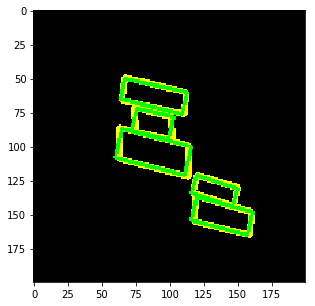

In [15]:
origin_polys = polys.copy()
new_polys=[]
for poly in polys:
    new_polys.append(revise_points(poly))
new_polys = np.stack(new_polys)

blank = np.zeros_like(image)
cv2.polylines(blank,
              origin_polys.astype(np.int32),
              True,(255,255,0),
              3)
cv2.polylines(blank,
              new_polys.astype(np.int32),
              True,(0,255,0),
              2)
plt.figure(figsize=(10,5))
plt.imshow(blank[450:650,200:400])
plt.show()

5) 학습에 들어갈 출력값($y_{pred}$) 만들기
----

In [16]:
def generate_feature_map(image, polys, scale=4):
    height, width = image.shape[:2]
    h = height // scale
    w = width // scale
    
    score_map = np.zeros((h, w), dtype=np.uint8)
    geo_map = np.zeros((h, w, 5), dtype=np.float32)
    poly_mask = np.zeros((h, w), dtype=np.uint8)
    
    polys = polys.copy()/4
    return score_map, geo_map, poly_mask, polys

def angle(pt1, pt2):
    return np.arctan2(pt1[1] - pt2[1], pt1[0]-pt2[0])

In [17]:
def generate_output(image, polys, fm_scale=4, scale=32):
    # 특징 맵의 크기에 맞게 score_map, geo_map 만들기
    score_map, geo_map, poly_mask, polys = generate_feature_map(image, polys, fm_scale)

    # 점 위치 정렬하기
    polys = reorder_clockwise(polys)
    # Reference 길이 맞추기
    rs = get_reference_length(polys)

    for poly_idx, (poly, r) in enumerate(zip(polys, rs)):
        inner_poly = shrink_quandrangle(poly.copy(), r)

        cv2.fillPoly(score_map, [inner_poly.astype(np.int32)], 1)
        cv2.fillPoly(poly_mask, [inner_poly.astype(np.int32)], poly_idx+1)

        coords_in_poly = np.argwhere(poly_mask == (poly_idx+1))

        poly = revise_points(poly)
        p0, p1, p2, p3 = fm_scale * poly
        theta = angle(p1, p0)
        for y, x in coords_in_poly:
            point = fm_scale * np.array([x, y], dtype=np.float32)
            # top
            geo_map[y, x, 0] = calculate_point_line_distance(p0,p1,point)
            # right
            geo_map[y, x, 1] = calculate_point_line_distance(p1,p2,point)
            # bottom
            geo_map[y, x, 2] = calculate_point_line_distance(p2,p3,point)
            # left
            geo_map[y, x, 3] = calculate_point_line_distance(p3,p0,point)
            # angle
            geo_map[y, x, 4] = theta
    
    score_map = score_map.astype(np.float32)
    return score_map, geo_map

In [18]:
fm_scale = 4
image, polys = dataset[index]

image, polys = normalize_shape(image, polys, scale=32)
score_map, geo_map = generate_output(image, polys,fm_scale)

In [19]:
print("score map의 크기 : ", score_map.shape)
print("geo map의 크기 : ", geo_map.shape)

score map의 크기 :  (184, 320)
geo map의 크기 :  (184, 320, 5)


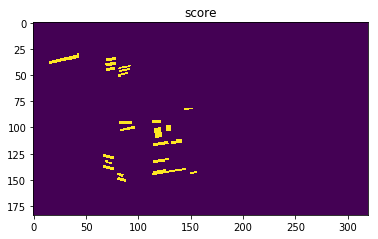

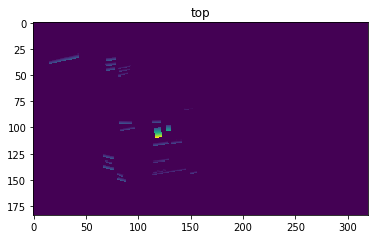

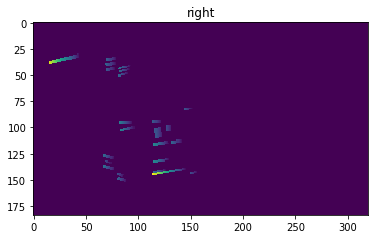

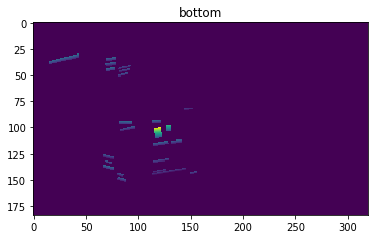

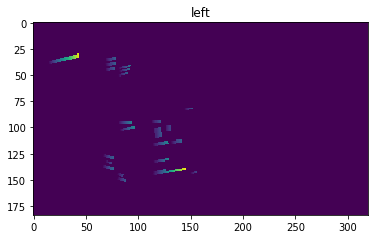

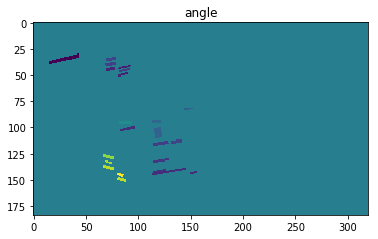

In [20]:
plt.title('score')
plt.imshow(score_map)
plt.show()

for i,channel in enumerate(['top','right','bottom','left','angle']):
    plt.title(channel)
    plt.imshow(geo_map[:,:,i])
    plt.show()

5) 출력값을 quandrangle로 복원하기
----

In [21]:
def restore_quandrangle(score_map, geo_map, threshold=0.5,fm_scale=4):
    h, w = geo_map.shape[:2]
    coords = np.mgrid[0:fm_scale*h:fm_scale,
                      0:fm_scale*w:fm_scale].transpose(1,2,0) # (h, w, 2)
    
    exist_score_map = score_map[np.where(score_map>=threshold)]
    exist_coords = coords[np.where(score_map>=threshold)]
    exist_geo_map = geo_map[np.where(score_map>=threshold)]

    p_y, p_x = np.split(exist_coords,2, axis=1)
    top, right, bottom, left, theta = np.split(exist_geo_map, 5, axis=1)
    
    top_y = p_y - top
    bot_y = p_y + bottom
    left_x = p_x - left
    right_x = p_x + right

    tl = np.concatenate([left_x , top_y],axis=1)
    tr = np.concatenate([right_x, top_y],axis=1)
    br = np.concatenate([right_x, bot_y],axis=1)
    bl = np.concatenate([left_x , bot_y],axis=1)
    
    center_x = np.mean([left_x, right_x],axis=0)
    center_y = np.mean([top_y, bot_y],axis=0)
    center = np.concatenate([center_x,center_y],axis=1)

    shift_tl = tl - center
    shift_tr = tr - center
    shift_bl = bl - center
    shift_br = br - center

    theta = np.squeeze(theta)
    x_rot_matrix = np.stack([np.cos(theta), -np.sin(theta)],axis=1)
    y_rot_matrix = np.stack([np.sin(theta), np.cos(theta)],axis=1)

    rotated_tl_x = (np.sum(x_rot_matrix * shift_tl, axis=1) + center[:,0])
    rotated_tl_y = (np.sum(y_rot_matrix * shift_tl, axis=1) + center[:,1])

    rotated_tr_x = (np.sum(x_rot_matrix * shift_tr, axis=1) + center[:,0])
    rotated_tr_y = (np.sum(y_rot_matrix * shift_tr, axis=1) + center[:,1])

    rotated_br_x = (np.sum(x_rot_matrix * shift_br, axis=1) + center[:,0])
    rotated_br_y = (np.sum(y_rot_matrix * shift_br, axis=1) + center[:,1])
    
    rotated_bl_x = (np.sum(x_rot_matrix * shift_bl, axis=1) + center[:,0])
    rotated_bl_y = (np.sum(y_rot_matrix * shift_bl, axis=1) + center[:,1])

    rotated_tl = np.stack([rotated_tl_x,rotated_tl_y],axis=-1)
    rotated_tr = np.stack([rotated_tr_x,rotated_tr_y],axis=-1)
    rotated_bl = np.stack([rotated_bl_x,rotated_bl_y],axis=-1)
    rotated_br = np.stack([rotated_br_x,rotated_br_y],axis=-1)
    
    rotated_polys = np.stack([rotated_tl,
                          rotated_tr,
                          rotated_br,
                          rotated_bl],axis=1)
    
    return rotated_polys, exist_score_map

In [22]:
def restore_quandrangle_tf(score_map, geo_map, threshold=0.5,fm_scale=4):
    h,w, _ = tf.shape(geo_map)

    xs,ys = tf.meshgrid(tf.range(0,w*fm_scale,fm_scale),
                        tf.range(0,h*fm_scale,fm_scale),)
    coords = tf.stack([ys,xs],axis=-1)
    coords = tf.cast(coords,tf.float32)

    indices = tf.where(score_map>=threshold)
    exist_score_map = tf.gather_nd(score_map, indices)
    exist_coords = tf.gather_nd(coords,indices)
    exist_geo_map = tf.gather_nd(geo_map,indices)

    p_y, p_x = tf.split(exist_coords,2, axis=1)
    top, right, bottom, left, theta = tf.split(exist_geo_map, 5, axis=1)

    top_y = p_y - top
    bot_y = p_y + bottom
    left_x = p_x - left
    right_x = p_x + right

    tl = tf.concat([left_x , top_y],axis=1)
    tr = tf.concat([right_x, top_y],axis=1)
    br = tf.concat([right_x, bot_y],axis=1)
    bl = tf.concat([left_x , bot_y],axis=1)

    center_x = tf.reduce_mean([left_x, right_x],axis=0)
    center_y = tf.reduce_mean([top_y, bot_y],axis=0)
    center = tf.concat([center_x,center_y],axis=1)

    shift_tl = tl - center
    shift_tr = tr - center
    shift_bl = bl - center
    shift_br = br - center

    theta = tf.squeeze(theta)
    x_rot_matrix = tf.stack([np.cos(theta), -np.sin(theta)],axis=1)
    y_rot_matrix = tf.stack([np.sin(theta), np.cos(theta)],axis=1)

    rotated_tl_x = (tf.reduce_sum(x_rot_matrix * shift_tl, axis=1) 
                    + center[:,0])
    rotated_tl_y = (tf.reduce_sum(y_rot_matrix * shift_tl, axis=1) 
                    + center[:,1])

    rotated_tr_x = (tf.reduce_sum(x_rot_matrix * shift_tr, axis=1) 
                    + center[:,0])
    rotated_tr_y = (tf.reduce_sum(y_rot_matrix * shift_tr, axis=1) 
                    + center[:,1])

    rotated_br_x = (tf.reduce_sum(x_rot_matrix * shift_br, axis=1) 
                    + center[:,0])
    rotated_br_y = (tf.reduce_sum(y_rot_matrix * shift_br, axis=1) 
                    + center[:,1])

    rotated_bl_x = (tf.reduce_sum(x_rot_matrix * shift_bl, axis=1) 
                    + center[:,0])
    rotated_bl_y = (tf.reduce_sum(y_rot_matrix * shift_bl, axis=1) 
                    + center[:,1])

    rotated_tl = tf.stack([rotated_tl_x,rotated_tl_y],axis=-1)
    rotated_tr = tf.stack([rotated_tr_x,rotated_tr_y],axis=-1)
    rotated_bl = tf.stack([rotated_bl_x,rotated_bl_y],axis=-1)
    rotated_br = tf.stack([rotated_br_x,rotated_br_y],axis=-1)

    rotated_polys = tf.stack([rotated_tl,rotated_tr,
                              rotated_br,rotated_bl],axis=1)
    
    return rotated_polys, exist_score_map

>  Minor한 문제로 비추어지는데, geo_map으로 갔다가 다시 quandrangle할 때 약간의 미스매치가 발생합니다. <br>
>  이 문제는 일단 Issue로만 남기고자 합니다.

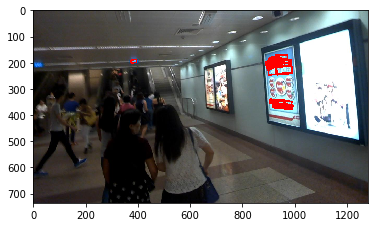

In [23]:
index = 4
image, polys = dataset[index]

image, polys = normalize_shape(image, polys, scale=32)
score_map, geo_map = generate_output(image, polys,fm_scale)

rotated_polys, score_polys = restore_quandrangle(score_map,geo_map)
rotated_polys_tf, score_polys_tf = restore_quandrangle_tf(score_map,geo_map)
ex1 = image.copy()
cv2.polylines(ex1,rotated_polys.astype(np.int32),True,(255,0,0),3)

plt.imshow(ex1)
plt.show()

In [24]:
np.testing.assert_array_almost_equal(rotated_polys,
                                     rotated_polys_tf,
                                     decimal=3)
np.testing.assert_array_almost_equal(score_polys,
                                     score_polys_tf,
                                     decimal=3)
# 구현 테스트

6) Non Maximum Suppression 적용하기
----

In [ ]:
import numpy as np
from shapely.geometry import Polygon

def locality_aware_NMS(polys, scores, thr=0.3):
    '''
    Locality Aware Non-Maximum Suppression
    '''
    selected_polys = []
    selected_scores = []
    prev = None
    for poly, score in zip(polys, scores):
        if prev is None:
            pass
        elif calculate_IoU(poly, prev[0]) > thr:
            poly = (score * poly + prev[0] * prev[1]) / (score + prev[1])
            score = (score + prev[1])
        else:
            selected_polys.append(poly)
            selected_scores.append(score)
        prev = poly, score

    if prev:        
        selected_polys.append(prev[0])
        selected_scores.append(prev[1])        
        return NMS(np.stack(selected_polys), 
                   np.stack(selected_scores), thr)
    else:
        return np.array([])

def NMS(polys, scores, thr=0.3):
    indices = np.argsort(scores)[::-1]
    keep = []
    while indices.size:
        idx, indices = indices[0], indices[1:]
        keep.append(idx)
        ovps = np.array([calculate_IoU(polys[idx], polys[t])
                         for t in indices])
        indices = indices[np.where(ovps <= thr)[0]]
    return polys[keep]


def calculate_IoU(true_poly, pred_poly):
    g = Polygon(true_poly)
    p = Polygon(pred_poly)

    union = g.union(p).area
    if union > 0:
        intersection = g.intersection(p).area
        return intersection / union
    else:
        return 0

In [ ]:
%%timeit -n5
choosed_polys = locality_aware_NMS(rotated_polys, score_polys)

In [ ]:
rotated_polys, score_polys = restore_quandrangle(score_map,geo_map)
print(rotated_polys.shape)

choosed_polys = locality_aware_NMS(rotated_polys, score_polys)
print(choosed_polys.shape)

ex1 = image.copy()
cv2.polylines(ex1,choosed_polys.astype(np.int32),True,(255,0,0),3)

plt.imshow(ex1)
plt.show()


#  

---

    Copyright(c) 2019 by Public AI. All rights reserved.<br>
    Writen by PAI, SangJae Kang ( rocketgrowthsj@publicai.co.kr )  last updated on 2019/04/17

---